In [84]:
# Imported dependancies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [85]:
import numpy as np
import pandas as pd

In [86]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [87]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_

In [88]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [89]:
# Reflected an existing database into a new model
Base = automap_base()
# Reflected the tables
Base.prepare(engine, reflect=True)

In [90]:
# Viewed all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [91]:
# Saved references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [92]:
# Created session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [93]:
# Displayed column name and type
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [94]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [95]:
# Extracted all dates and precipitation data and ordered in descending order
prec_all = session.query(measurement.date, measurement.prcp).\
            order_by(measurement.date.desc()).all()

for row in prec_all[:10]:
    print(row.date,row.prcp)

2017-08-23 0.0
2017-08-23 0.0
2017-08-23 0.08
2017-08-23 0.45
2017-08-22 0.0
2017-08-22 0.0
2017-08-22 0.5
2017-08-21 0.0
2017-08-21 0.02
2017-08-21 None


In [96]:
#From the above query, we know the last date data point is 2017-08-23
# Retrieve the data and precipitation scores - 1 year ago from the last data point in the database
sel = [measurement.date, measurement.prcp]
one_year_ago = dt.date(2017,8,23) - dt.timedelta(days=365)
#print(one_year_ago)

prcp_1yr = session.query(*sel).filter(func.date(measurement.date) >= one_year_ago)

for row in prcp_1yr[:10]:
    print(row.date,row.prcp)

2016-08-23 0.0
2016-08-24 0.08
2016-08-25 0.08
2016-08-26 0.0
2016-08-27 0.0
2016-08-28 0.01
2016-08-29 0.0
2016-08-30 0.0
2016-08-31 0.13
2016-09-01 0.0


In [97]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_1yr, columns=['date','prcp'])
prcp_df = prcp_df.sort_values('date')
#prcp_df
prcp_df.set_index('date')
#prcp_df

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


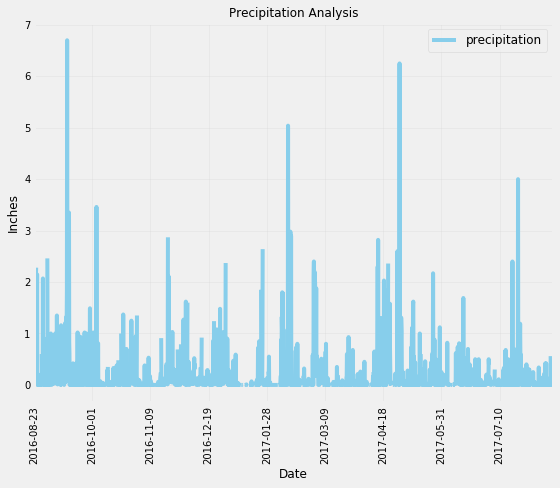

In [98]:
# Use Pandas Plotting with Matplotlib to plot the data
x_axis = np.arange(len(prcp_df.index))

prcp_df.plot('date','prcp',label='precipitation',color='skyblue',figsize=(8,7))
plt.grid(alpha=0.2)
plt.xlabel("Date",fontsize=12)
plt.ylabel("Inches",fontsize=12)
plt.title("Precipitation Analysis",fontsize=12)
plt.legend(loc='best',fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(rotation=90,fontsize=10)
plt.tight_layout()
plt.savefig('Output/Precipitation_Analysis.png')
plt.show()

In [99]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [100]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(measurement).group_by(measurement.station).count()
print(f"Number of stations: {station_count}")

Number of stations: 9


In [101]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [measurement.station,func.count(measurement.station)]

station_count = session.query(*sel).group_by(measurement.station).order_by(func.count(measurement.station).desc())

#for station in station_count[:1]:
    #print(station.station,station[1])
    
station_df = pd.DataFrame(station_count,columns=['Station','Count'])
station_df.set_index('Station')

,Count
Station,
USC00519281,2772
USC00519397,2724
USC00513117,2709
USC00519523,2669
USC00516128,2612
USC00514830,2202
USC00511918,1979
USC00517948,1372
USC00518838,511


In [102]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
sel = [measurement.station,func.count(measurement.station),\
       func.min(measurement.tobs),func.max(measurement.tobs),func.avg(measurement.tobs)]

temp_stats = session.query(*sel).filter(measurement.station == station_df.Station[0])

#for stat in temp_stats:
    #print(stat)
    
temp_stats_df = pd.DataFrame(temp_stats,columns=['Station','Count','Minimum temperature',
                                                 'Maximum temperature','Average temperature'])
temp_stats_df.set_index('Station')

,Count,Minimum temperature,Maximum temperature,Average temperature
Station,,,,
USC00519281,2772,54.0,85.0,71.663781


In [103]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
sel = [measurement.station,measurement.date,measurement.tobs]

temp_data = session.query(*sel).filter(measurement.station == station_df.Station[0]).\
                                filter(func.date(measurement.date) >= one_year_ago)

#for stat in temp_data[:10]:
    #print(stat)
    
temp_data_df = pd.DataFrame(temp_data,columns=['Station','Date','tobs'])
temp_data_df.set_index('Station')

,Date,tobs
Station,,
USC00519281,2016-08-23,77.0
USC00519281,2016-08-24,77.0
USC00519281,2016-08-25,80.0
USC00519281,2016-08-26,80.0
USC00519281,2016-08-27,75.0
...,...,...
USC00519281,2017-08-14,77.0
USC00519281,2017-08-15,77.0
USC00519281,2017-08-16,76.0


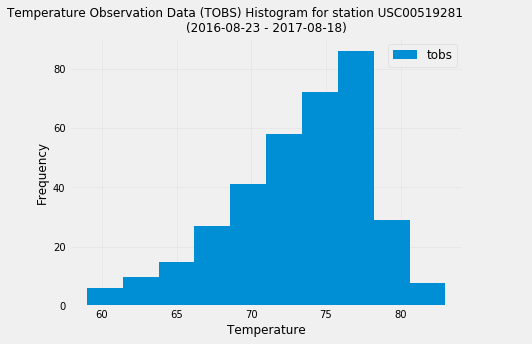

In [104]:
#  Plot the above results as a histogram
temp_data_df.plot('Date','tobs',kind='hist',figsize=(7,5))
plt.grid(alpha=0.2)
plt.xlabel("Temperature",fontsize=12)
plt.ylabel("Frequency",fontsize=12)
plt.title(f"Temperature Observation Data (TOBS) Histogram for station {temp_data_df.Station[0]}\
                \n({temp_data_df.Date[0]} - {temp_data_df.Date[len(temp_data_df.Date)-1]})",fontsize=12,loc='center')
plt.legend(loc='best',fontsize=12)
plt.yticks(fontsize=10)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.savefig('Output/TOB_Histogram.png')
plt.show()

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

NameError: name 'Measurement' is not defined

In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
